<a href="https://colab.research.google.com/github/ayush-99/Smoke-Fire_CNN/blob/main/Smoke_fire_detection_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Smoke-Fire Detection***

This notebook contains code where I try different techniques to solve the problem of Fire-Smoke detection using CNNs

Unfortunately, the dataset I coud get a hold of(from kaggle) wasn't big enough. So, I had to do some manual scavenging by checking for images and videos of fire/smoke from YouTube which was especially taken from CCTV cameras as the usecase also involves them.
Then, I converted these videos frame by frame to Images and stacked them in different Smoke, Fire, Default folders to then upload to the Google Drive and mount them on this Google Colaboratory to work with.

Google Colaboratory was chosen as it offers more RAM and better GPU than my local box and also doesnt involve the complex process of CUDA and installing GPU accelerated tf 2.3.x

The reason why I decided to go with predicting the class(smoke/fire/default) on the whole image instead of an object detection bounding box which would tell which part of the image the fire/smoke occur was since the dataset contains a lot of CCTV image and goal is to raise an alarm as soon as fire/smoke is spotted, it isn't important at that time to know where in the image it is, as CCTV cover a concentrated area



Something like that would only be required on a self-driving car, so that it stays away from the radius of the fire/accident 

***NOTE:***
1. On Google Colab, there's table of contents on the left to skip to any part of the code that you wish

2. In the "Results and furthur acitons",after every model training and visualizing how it has done, there's a part called **Key points** where I explain the outcome of that model and what steps I take to improve it

### Libraries

In [2]:
#importing required libraries

import tensorflow as tf
tf.__version__

'2.3.0'

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from glob import glob

## Understanding the data

### Accessing the data

In [4]:
#Defining the training, validation path. This helps to easily call it and not write the whole path every time we want to access any data

train_path = '/content/drive/My Drive/dataset/train'
val_path = '/content/drive/My Drive/dataset/test'

In [5]:
#We can see the our data is segregated into folders which act as classes for this classification

folders = glob('/content/drive/My Drive/dataset/train/*')
print('Number of classes:', len(folders), '\nThese classes are: ', os.listdir(train_path))

Number of classes: 3 
These classes are:  ['default', 'fire', 'smoke']


### Visualizing the data

In [ ]:
#selecting a random image from the train dataset

os.listdir(train_path+"/fire")[5]

'78.newsimage-1-00345DD7-3D5D-4242-AA30-8000B2F650CD.jpeg'

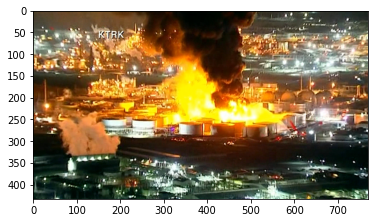

In [ ]:
#Visualizing this image just to check out some random data

fire_img1 = train_path+"/fire/78.newsimage-1-00345DD7-3D5D-4242-AA30-8000B2F650CD.jpeg"
show_fire_img1 = imread(fire_img1)

plt.imshow(show_fire_img1)

In [ ]:
#Performing the same above process for smoke class

os.listdir(train_path+"/smoke")[10]

'img_944.jpg'

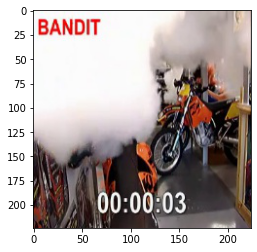

In [ ]:
smoke_img1 = train_path+"/smoke/img_944.jpg"
show_smoke_img1 = imread(smoke_img1)

plt.imshow(show_smoke_img1)

In [ ]:
print('Number of images in fire class: ', len(os.listdir(train_path+"/fire")))
print('Number of images in smoke class: ', len(os.listdir(train_path+"/smoke")))
print('Number of images in default class: ', len(os.listdir(train_path+"/default")))

Number of images in fire class:  715
Number of images in smoke class:  793
Number of images in default class:  534


We can already see that the amount of data we have is quite less to perform a CNN and we might have over-fitting problems later

### Shaping the images

In [ ]:
show_smoke_img1.shape

(224, 224, 3)

In [ ]:
show_fire_img1.shape

(433, 770, 3)

We can see these 2 images have different shapes. We need to get a constant shape to perform better on the Network

Also, if we are going to use Transfer Learning, it is required for certain architectures to provide specific input shapes||
eg.(244,244,3) for VGG16

In [ ]:
#This code cell itterates through all images in the train folder and stores their input shape(x,y,z) x,y in 2 lists as z is always = 3(RGB image)

dim1 = []                                                           #Initializing list which will store x,y as dim1, dim2 respectively
dim2 = []
for image_filename in os.listdir(train_path+'/fire'):               #Loop to itterate through the fire class training image
  img = imread(train_path+'/fire'+'/'+image_filename)               #Reading the image shape and storing it in img
  d1,d2,colors = img.shape                                          #performing tuple unpacking and storing x,y in d1,d2
  dim1.append(d1)                                                   #Finally appending it into the 2 lists
  dim2.append(d2)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


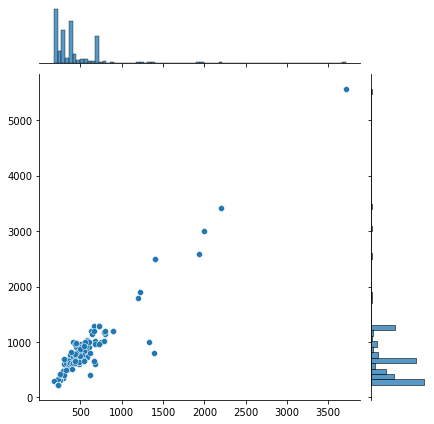

In [ ]:
sns.jointplot(dim1,dim2)                                            #Visualize the spectrum of shapes

Most image have a smaller resolution with some outliers of very high resolution images

## Modeling

### Libraries

In [6]:
#Importing required libraries 

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [7]:
image_size = [224,224,3]  #standardizing the image shape - will be used later while sending images into the modle

### Data Augmentation

As I have been reiterating, I do not have enough data at all. So data augmentation helps in increasing the dataset by adding edited versions of existing images

We also pre-process our image according to the acceptable VGG16 preprocessed requirements

In [8]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest', # Fill in missing pixels with the nearest filled value
                               preprocessing_function=tf.keras.applications.vgg16.preprocess_input
                              )

In [9]:
train_batches = image_gen.flow_from_directory(directory = train_path, target_size=(224,224), batch_size = 16)
val_batches = image_gen.flow_from_directory(directory = val_path, target_size=(224,224), batch_size = 16)

Found 2042 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [ ]:
#https://www.tensorflow.org/tutorials/images/classification#visualize_the_data
#function to visualize the batch of train data. Note it looks different than normal because it is preprocessed as per VGG16 requirements


imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

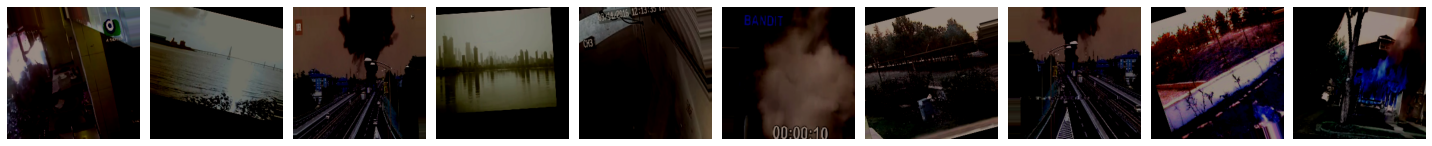

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

### Creating the model

In [10]:
#Checking out and making sure that our train shapes are correct
#https://www.tensorflow.org/tutorials/images/transfer_learning#feature_extraction

for image_batch, labels_batch in train_batches:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16, 3)


In [11]:
#Downloading and naming the VGG16 as the base model. Unfreezing the last 3 layers and trainning only on those, rest will be freezed

base_model = VGG16(input_shape=image_size, weights = 'imagenet', include_top= False, classes = len(folders))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

As we can see, the architecture isn't complete. This is because we are going to fine tune the bottom few layers as per our need but majyority of the architecture is going to remain frozen

In [12]:
#Freezing the top layers

for layer in base_model.layers:
  layer.trainable = False

In [13]:
#This will be the shape after the image comes out of the VGG16 as we can see the shapes of the last layer in the architecture matches - (7,7,512). 16 = batch size

image_batch, label_batch = next(iter(train_batches))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 512)


In [ ]:
#Creating our last layers which will then be added to the original base_model which is VGG16

x = Flatten()(base_model.output)
fc1 = Dense(4096, activation = 'relu')(x)
fc2 = Dense(4096, activation = 'relu')(fc1)
prediction = Dense(len(folders), activation = 'softmax')(fc2)
model = Model(inputs = base_model.input, outputs = prediction)

In [ ]:
#This is how our final model looks like. The last few layers are different

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Training the model

In [ ]:
#As seen these are the parameter that we will be training the last few layers on

model.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [ ]:
len(train_batc)

128

In [ ]:
#tr will save all the log of the model. We can make graphs etc later to analyse this. Tensorboard is also an option, but isn't used here as it is hard to visualize it on Git

tr  = model.fit_generator(train_batches, epochs = 10, validation_data=val_batches, steps_per_epoch= len(train_batches), validation_steps= len(val_batches) )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
128/128 [==============================] - 1067s 8s/step - loss: 2.0545 - accuracy: 0.6939 - val_loss: 0.7307 - val_accuracy: 0.6862
Epoch 2/10
128/128 [==============================] - 51s 396ms/step - loss: 0.4527 - accuracy: 0.8252 - val_loss: 0.8502 - val_accuracy: 0.7126
Epoch 3/10
128/128 [==============================] - 51s 396ms/step - loss: 0.2995 - accuracy: 0.8864 - val_loss: 0.7133 - val_accuracy: 0.7449
Epoch 4/10
128/128 [==============================] - 51s 396ms/step - loss: 0.2354 - accuracy: 0.9128 - val_loss: 0.8362 - val_accuracy: 0.7273
Epoch 5/10
128/128 [==============================] - 51s 400ms/step - loss: 0.2300 - accuracy: 0.9167 - val_loss: 1.1597 - val_accuracy: 0.6979
Epoch 6/10
128/128 [==============================] - 51s 398ms/step - loss: 0.2420 - accuracy: 0.9153 - val_loss: 0.6186 - val_accuracy: 0.7507
Epoch 7/10
128/128 [==============================] - 5

Rite of the bat, we can see that our training accuracy is really good but validation accuracy isnt. But we will plot this to get a better intuition

In [ ]:
type(tr)

tensorflow.python.keras.callbacks.History

### Results and furthur acitons

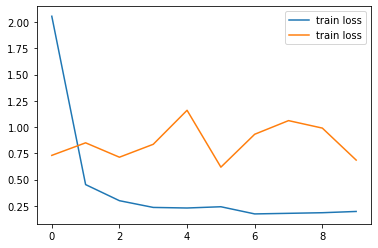

In [ ]:
plt.plot(tr.history['loss'], label = 'train loss')
plt.plot(tr.history['val_loss'], label = 'train loss')
plt.legend()
plt.show()

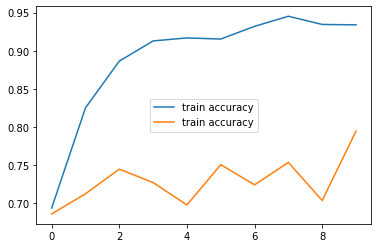

In [ ]:
plt.plot(tr.history['accuracy'], label = 'train accuracy')
plt.plot(tr.history['val_accuracy'], label = 'train accuracy')
plt.legend()
plt.show()

**Key points**

1. We see that there's a gap between train, validaiton accuracy
2. I decided to train it over more epocs as the accuracy was increasing and just to see the over-all trend and where this will go



In [19]:
model2 = Model(inputs = base_model.input, outputs = prediction)

In [20]:
model2.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [21]:
#training the same model on more epochs just to see the overall trend as stated above

tr2  = model2.fit_generator(train_batches, epochs = 15, validation_data=val_batches, steps_per_epoch= len(train_batches), validation_steps= len(val_batches) )

Epoch 1/15
128/128 [==============================] - 52s 403ms/step - loss: 0.1359 - accuracy: 0.9510 - val_loss: 0.9857 - val_accuracy: 0.7742
Epoch 2/15
128/128 [==============================] - 51s 400ms/step - loss: 0.1516 - accuracy: 0.9525 - val_loss: 1.2983 - val_accuracy: 0.7683
Epoch 3/15
128/128 [==============================] - 51s 400ms/step - loss: 0.1959 - accuracy: 0.9334 - val_loss: 1.2399 - val_accuracy: 0.7537
Epoch 4/15
128/128 [==============================] - 51s 398ms/step - loss: 0.1415 - accuracy: 0.9466 - val_loss: 1.5338 - val_accuracy: 0.7478
Epoch 5/15
128/128 [==============================] - 52s 403ms/step - loss: 0.1078 - accuracy: 0.9598 - val_loss: 1.3960 - val_accuracy: 0.7449
Epoch 6/15
128/128 [==============================] - 51s 400ms/step - loss: 0.1781 - accuracy: 0.9432 - val_loss: 1.4558 - val_accuracy: 0.7419
Epoch 7/15
128/128 [==============================] - 51s 402ms/step - loss: 0.1199 - accuracy: 0.9608 - val_loss: 1.7790 - val_ac

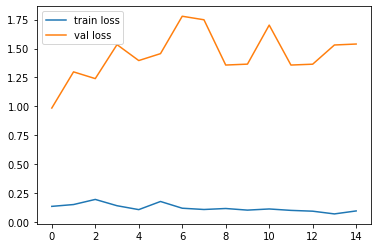

In [22]:
plt.plot(tr2.history['loss'], label = 'train loss')
plt.plot(tr2.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

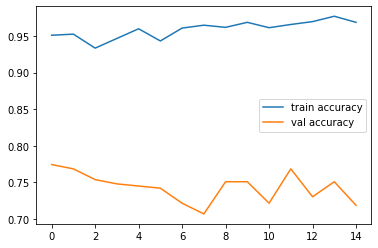

In [23]:
plt.plot(tr2.history['accuracy'], label = 'train accuracy')
plt.plot(tr2.history['val_accuracy'], label = 'val accuracy')
plt.legend()
plt.show()

**Key points:**

1. It is clear that the model is overfitting as seen by the huge gap between train and validation accuracy
2. This is clearly due to the less data
3. Furthur, we could try some regularization techniques or decreasing the model complexity



**Decreasing model complexity by removing a Fully connected layer and then training**

In [ ]:
x = Flatten()(base_model.output)
fc1 = Dense(4096, activation = 'relu')(x)
prediction = Dense(len(folders), activation = 'softmax')(fc1)
model3 = Model(inputs = base_model.input, outputs = prediction)

model3.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [ ]:
model3.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

tr3  = model3.fit_generator(train_batches, epochs = 15, validation_data=val_batches, steps_per_epoch= len(train_batches), validation_steps= len(val_batches) )

Epoch 1/15
128/128 [==============================] - 51s 400ms/step - loss: 3.2784 - accuracy: 0.6641 - val_loss: 0.9841 - val_accuracy: 0.6657
Epoch 2/15
128/128 [==============================] - 51s 399ms/step - loss: 0.4532 - accuracy: 0.8472 - val_loss: 0.7504 - val_accuracy: 0.7185
Epoch 3/15
128/128 [==============================] - 51s 400ms/step - loss: 0.3705 - accuracy: 0.8688 - val_loss: 0.7838 - val_accuracy: 0.7331
Epoch 4/15
128/128 [==============================] - 51s 399ms/step - loss: 0.2941 - accuracy: 0.8952 - val_loss: 0.8854 - val_accuracy: 0.7214
Epoch 5/15
128/128 [==============================] - 51s 395ms/step - loss: 0.1705 - accuracy: 0.9339 - val_loss: 0.8744 - val_accuracy: 0.7654
Epoch 6/15
128/128 [==============================] - 50s 388ms/step - loss: 0.2293 - accuracy: 0.9133 - val_loss: 0.7538 - val_accuracy: 0.7742
Epoch 7/15
128/128 [==============================] - 50s 389ms/step - loss: 0.2070 - accuracy: 0.9251 - val_loss: 0.7538 - val_ac

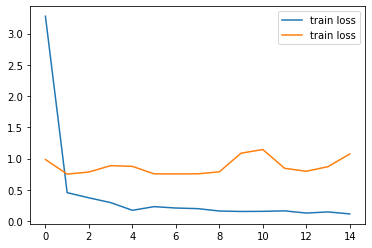

In [ ]:
plt.plot(tr3.history['loss'], label = 'train loss')
plt.plot(tr3.history['val_loss'], label = 'train loss')
plt.legend()
plt.show()

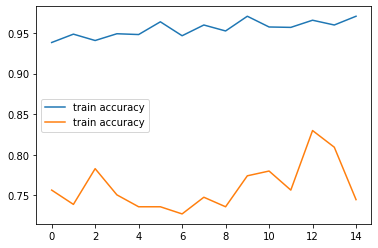

In [ ]:
plt.plot(tr2.history['accuracy'], label = 'train accuracy')
plt.plot(tr2.history['val_accuracy'], label = 'train accuracy')
plt.legend()
plt.show()

**Key points**

1. The loss have come a little together butt there's still a bug difference between the accuracies
2. We can simplify the architecture furthur to see if it helps reduce high varience

In [ ]:
#We remove the FC layers and direclty add the prediction layer to make the model simpler

x = Flatten()(base_model.output)
prediction = Dense(len(folders), activation = 'softmax')(x)
model4 = Model(inputs = base_model.input, outputs = prediction)

model4.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

In [ ]:
model4.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

tr4  = model4.fit_generator(train_batches, epochs = 15, validation_data=val_batches, steps_per_epoch= len(train_batches), validation_steps= len(val_batches) )

Epoch 1/15
128/128 [==============================] - 51s 396ms/step - loss: 0.6491 - accuracy: 0.7449 - val_loss: 0.8946 - val_accuracy: 0.6569
Epoch 2/15
128/128 [==============================] - 50s 394ms/step - loss: 0.3724 - accuracy: 0.8595 - val_loss: 0.8308 - val_accuracy: 0.6950
Epoch 3/15
128/128 [==============================] - 50s 394ms/step - loss: 0.3370 - accuracy: 0.8756 - val_loss: 0.9141 - val_accuracy: 0.7097
Epoch 4/15
128/128 [==============================] - 50s 392ms/step - loss: 0.3448 - accuracy: 0.8786 - val_loss: 1.1971 - val_accuracy: 0.7185
Epoch 5/15
128/128 [==============================] - 50s 392ms/step - loss: 0.2353 - accuracy: 0.9192 - val_loss: 0.8129 - val_accuracy: 0.7449
Epoch 6/15
128/128 [==============================] - 50s 393ms/step - loss: 0.2474 - accuracy: 0.9055 - val_loss: 1.1187 - val_accuracy: 0.6716
Epoch 7/15
128/128 [==============================] - 51s 395ms/step - loss: 0.2118 - accuracy: 0.9207 - val_loss: 1.1992 - val_ac

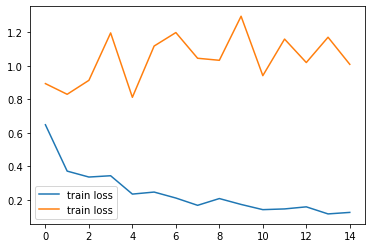

In [ ]:
plt.plot(tr4.history['loss'], label = 'train loss')
plt.plot(tr4.history['val_loss'], label = 'train loss')
plt.legend()
plt.show()

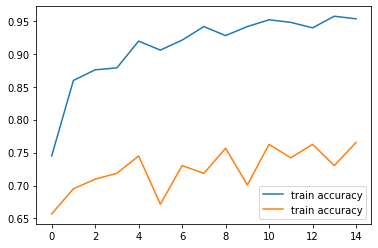

In [ ]:
plt.plot(tr4.history['accuracy'], label = 'train accuracy')
plt.plot(tr4.history['val_accuracy'], label = 'train accuracy')
plt.legend()
plt.show()

**Key points:**

1. A minor improvement can be seen with respect to decreasing overfitting, it is still not enough
2. Now, regularization is added like dropout to see if that helps


In [14]:
#A new dropout is added

x = Flatten()(base_model.output)
prediction = Dense(len(folders), activation = 'softmax', )(x)
layer = tf.keras.layers.Dropout(0.5)(prediction)
model5 = Model(inputs = base_model.input, outputs = prediction)

model5.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [15]:
model5.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

tr5  = model5.fit_generator(train_batches, epochs = 15, validation_data=val_batches, steps_per_epoch= len(train_batches), validation_steps= len(val_batches) )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
128/128 [==============================] - 1957s 15s/step - loss: 0.6800 - accuracy: 0.7346 - val_loss: 0.8426 - val_accuracy: 0.6979
Epoch 2/15
128/128 [==============================] - 51s 399ms/step - loss: 0.4051 - accuracy: 0.8428 - val_loss: 0.8657 - val_accuracy: 0.6891
Epoch 3/15
128/128 [==============================] - 52s 403ms/step - loss: 0.2905 - accuracy: 0.8928 - val_loss: 0.7985 - val_accuracy: 0.7507
Epoch 4/15
128/128 [==============================] - 51s 397ms/step - loss: 0.2463 - accuracy: 0.9133 - val_loss: 0.8776 - val_accuracy: 0.7331
Epoch 5/15
128/128 [==============================] - 51s 398ms/step - loss: 0.2309 - accuracy: 0.9226 - val_loss: 1.2526 - val_accuracy: 0.6422
Epoch 6/15
128/128 [==============================] - 51s 398ms/step - loss: 0.2629 - accuracy: 0.9040 - val_loss: 0.9034 - val_accuracy: 0.7595
Epoch 7/15
128/128 [==============================] - 

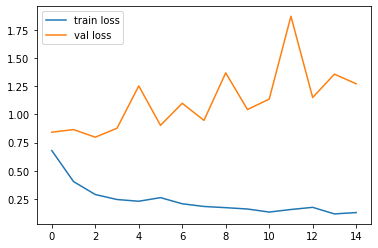

In [17]:
plt.plot(tr5.history['loss'], label = 'train loss')
plt.plot(tr5.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

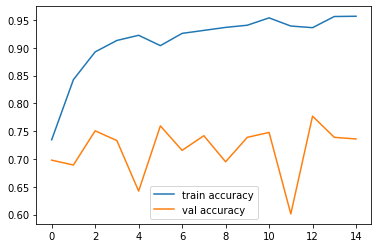

In [18]:
plt.plot(tr5.history['accuracy'], label = 'train accuracy')
plt.plot(tr5.history['val_accuracy'], label = 'val accuracy')
plt.legend()
plt.show()

**Key Points:**

1. It overfits even after adding a dropout of 0.5
2. Maybe trying a different basemodel like that of a MobileNetv2 which is simple might work - DOne in the notebook2 as variables would get mixed and might get difficult
3. Try leaving the transfer learning method and create a simple model of my own and train that on this dataset

## Changing approach: My_model

As we saw different attempts of getting a good accuracy failing through transfer learning, I tried VGG16 network and the simple MobileNetV2(Notebook2) on this data which is small for a Computer Vision task

My last attempt was to make a simple model of my own and train on this model and see how it performs. Perhaps a simple model would do the job.

In [24]:
#Starting from scratch and initializing my_model and defining the architecture. We are using dropout directly as we know the condition of our overfit
##https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters

my_model = Sequential()
my_model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_size, activation='relu',))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_size, activation='relu',))
my_model.add(MaxPooling2D(pool_size=(2, 2)))

my_model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_size, activation='relu',))
my_model.add(MaxPooling2D(pool_size=(2, 2)))


my_model.add(Flatten())


my_model.add(Dense(128))
my_model.add(Activation('relu'))

my_model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
my_model.add(Dense(3))
my_model.add(Activation('softmax'))

my_model.compile(optimizer = 'adam', loss = tf.keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [25]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)             0

Following the same data sugmentation and normalization techniques except for the vgg16 preprocess as we are not using one

In [26]:
my_image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [27]:
my_image_gen.flow_from_directory(train_path)

Found 2042 images belonging to 3 classes.


In [28]:
my_image_gen.flow_from_directory(val_path)

Found 341 images belonging to 3 classes.


In [29]:
train_image_gen = my_image_gen.flow_from_directory(train_path,
                                               target_size=image_size[:2],
                                                color_mode='rgb',
                                               batch_size=16)

Found 2042 images belonging to 3 classes.


In [30]:
val_image_gen = my_image_gen.flow_from_directory(val_path,
                                               target_size=image_size[:2],
                                                color_mode='rgb',
                                               batch_size=16)

Found 341 images belonging to 3 classes.


In [31]:
train_image_gen.class_indices

{'default': 0, 'fire': 1, 'smoke': 2}

In [32]:
results = my_model.fit_generator(train_image_gen,epochs=25,
                              validation_data=val_image_gen)

Epoch 1/25
128/128 [==============================] - 50s 392ms/step - loss: 1.0537 - accuracy: 0.4882 - val_loss: 1.0541 - val_accuracy: 0.5279
Epoch 2/25
128/128 [==============================] - 50s 388ms/step - loss: 0.8945 - accuracy: 0.5847 - val_loss: 1.0555 - val_accuracy: 0.5718
Epoch 3/25
128/128 [==============================] - 50s 388ms/step - loss: 0.8868 - accuracy: 0.6048 - val_loss: 1.0086 - val_accuracy: 0.5543
Epoch 4/25
128/128 [==============================] - 50s 390ms/step - loss: 0.8192 - accuracy: 0.6562 - val_loss: 1.1316 - val_accuracy: 0.5396
Epoch 5/25
128/128 [==============================] - 50s 388ms/step - loss: 0.7574 - accuracy: 0.6836 - val_loss: 1.0677 - val_accuracy: 0.5367
Epoch 6/25
128/128 [==============================] - 50s 392ms/step - loss: 0.6954 - accuracy: 0.7140 - val_loss: 0.8967 - val_accuracy: 0.5894
Epoch 7/25
128/128 [==============================] - 50s 388ms/step - loss: 0.6450 - accuracy: 0.7287 - val_loss: 0.8845 - val_ac

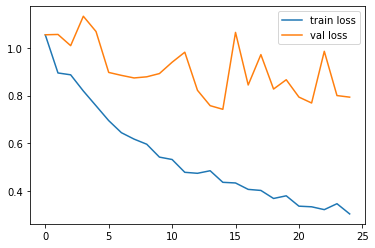

In [33]:
plt.plot(results.history['loss'], label = 'train loss')
plt.plot(results.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

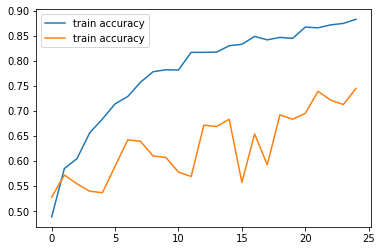

In [34]:
plt.plot(results.history['accuracy'], label = 'train accuracy')
plt.plot(results.history['val_accuracy'], label = 'train accuracy')
plt.legend()
plt.show()

**Key points:**

1. We see that this is staring to overfit too as the gap is increasing 
2. This teaches me that data is everything and more amount of energy and time has to be spent on getting the right amount of data for any computer vision task 

## Summary

1. Data is a very important part in computer vision as with less data, one is always overfitting even with the simplest of networks as we saw

2. After finding a small dataset from kaggle, I went on youtube and downloaded CCTV videos of fire, smoke etc and converted those frames into images for this task. CCTV footage was a good data choice as that is our usecase

3. The reason I selected Classifying the whole image into Smoke, Fire, Default rather than going for object detection techniques by using networks like YOLO was because in a cctv, if there's a smoke/fire, it needs attention and the furthur action is taken to deal with it as cctv covers a small area anyway. 
Using the object detection technique to draw bounding boxes and tell which part of the image these things occur would be good in the use case of a self-driving car

4. The reason why it would be useful in a self driving car is then the car can dodge it from a distance and not go near it but for the CCTV, we dont need it
Also, obj detection requires a complex network like that of YOLO and we need huge amounts of video data for that and we're already short of data so that didnt seem like an apt choice.

5. One takeaway for me is that of starting with a simple model first and then working my way up to complex ones. It's something i learnt but failed to apply here as i thought that a complex model would capture the information better.

6. If I started with a simple model first, i would see issues of overfitting staraight away and not look towards complex ones, but since i started with the complex one, i had to try many variation of models hoping to tackle the overfitting the model by trying simpler models and regularization.